# Making simple equation solver #


**Goal** : Making a simple equation solver to perform `+` , `-` , `/` and `*` based on images of the equation. Everything is build from stratch and we are using Keras Sequential Model for this.  


1. [Reading the data](#Reading-the-data)
2. [Verifying the data](#Verifying-the-data)
3. [Creating train test and validation set](#Creating-train-test-and-validation-set)
4. [Creating Sequential model](#Creating-Sequential-model)
5. [Training the model](#Training-the-model)
6. [Visualising the outcome](#Visualising-the-outcome)
7. [Model performance on equations](#Model-performance-on-equations)
8. [Keract for seeing inside the model](#Keract-for-seeing-inside-the-model)

# Reading the data #

Importing all the libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import os
import cv2
from sklearn import preprocessing
from pathlib import Path
from PIL import Image

Creating a list of symbols which we are going to use for training 

In [2]:
symbols_list = ['zero','one','two','three','four','five','six','seven','eight','nine','minus','plus','equal','div','decimal','times']

Loading the paths of all testing and training images

In [9]:
dataset_path = "./train"
train_image = []
train_label = []

for symbols_dir in os.listdir(dataset_path):
    if symbols_dir.split()[0] in symbols_list:
        for image in os.listdir(dataset_path + "/" + symbols_dir):
            train_label.append(symbols_dir.split()[0])
            train_image.append(dataset_path + "/" + symbols_dir + "/" + image)

In [10]:
eval_path = "./eval"
test_image = []
test_label = []

for symbols_dir in os.listdir(eval_path):
    if symbols_dir.split()[0] in symbols_list:
        for image in os.listdir(eval_path + "/" + symbols_dir):
            test_label.append(symbols_dir.split()[0])
            test_image.append(eval_path + "/" + symbols_dir + "/" + image)

In [11]:
print("Length of train_image : " , len(train_image) , " , length of labels list : " ,len(train_label))
print("Length of test_image : " , len(test_image) , " , length of labels list : " ,len(test_label))

Length of train_image :  7557  , length of labels list :  7557
Length of test_image :  1010  , length of labels list :  1010


# Verifying the data #

Let's see that we have 16 unique labels for both test and train

In [12]:
unique_test = list(set(test_label))
unique_train = list(set(train_label))
print("Length of test unique labels: " , len(unique_test) , " : " , unique_test)
print("Length of train unique labels: " , len(unique_train) , " : " , unique_train)

Length of test unique labels:  16  :  ['zero', 'equal', 'six', 'decimal', 'five', 'times', 'two', 'three', 'minus', 'div', 'four', 'eight', 'nine', 'plus', 'seven', 'one']
Length of train unique labels:  16  :  ['zero', 'equal', 'six', 'decimal', 'five', 'times', 'two', 'three', 'minus', 'div', 'four', 'eight', 'nine', 'plus', 'seven', 'one']


Loading the images and label and checking correctness

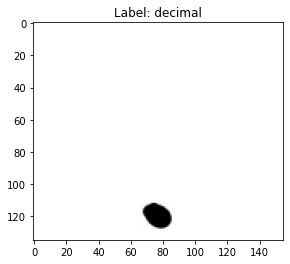

In [13]:
image = cv2.imread(train_image[140])
plt.imshow(image)
plt.title("Label: " + train_label[140])
plt.show()

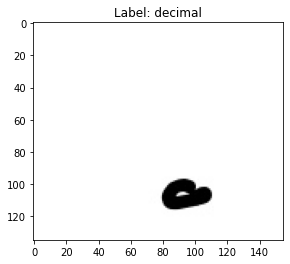

In [14]:
image = cv2.imread(train_image[500])
plt.imshow(image)
plt.title("Label: " + train_label[500])
plt.show()

# Creating train test and validation set #

In [15]:
test = np.array(cv2.imread(train_image[20]))
test.shape

(135, 155, 3)

Creating the X_train and X_test

In [16]:
X_train = []
X_test = []

# laoding the images from the path
for path in train_image:    
    img = cv2.imread(path)
    img = cv2.resize(img, (100, 100))
    img = np.array(img)
    X_train.append(img)

for path in test_image:    
    img = cv2.imread(path)
    img = cv2.resize(img, (100, 100))
    img = np.array(img)     
    X_test.append(img)

# creating numpy array from the images
X_train = np.array(X_train)
X_test = np.array(X_test)

Verifying the shape

In [17]:
X_train.shape

(7557, 100, 100, 3)

In [18]:
# normalizing the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (7557, 100, 100, 3)
X_test shape:  (1010, 100, 100, 3)


Creating the y_train and y_test

In [19]:
# label encoding the 16 symbols
label_encoder = preprocessing.LabelEncoder()
y_train_temp = label_encoder.fit_transform(train_label)
y_test_temp = label_encoder.fit_transform(test_label)

In [20]:
print("y_train_temp shape: ", y_train_temp.shape)
print("y_test_temp shape: ", y_test_temp.shape)

y_train_temp shape:  (7557,)
y_test_temp shape:  (1010,)


In [21]:
# creating matrix labels list
y_train = keras.utils.to_categorical(y_train_temp, 16)
y_test = keras.utils.to_categorical(y_test_temp, 16)


print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (7557, 16)
y_test shape:  (1010, 16)


# Creating Sequential model #

In [22]:
# using sequential model for training
model = Sequential()

# 1st layer and taking input in this of shape 100x100x3 ->  100 x 100 pixles and 3 channels
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(100, 100, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))

# maxpooling will take highest value from a filter of 2*2 shape
model.add(MaxPooling2D(pool_size=(2, 2)))

# it will prevent overfitting by making it hard for the model to idenify the images
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# last layer predicts 16 labels
model.add(Dense(16, activation="softmax"))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0

Visualising the model

In [23]:
# displaying the model
keras.utils.plot_model(model, "model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Training the model #

In [ ]:
# training the model
history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=200,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/200
121/121 [==============================] - ETA: 0s - loss: 1.8375 - accuracy: 0.4299

# Visualising the outcome #

In [ ]:
# displaying the model accuracy
plt.plot(history.history['accuracy'], label='train', color="red")
plt.plot(history.history['val_accuracy'], label='validation', color="blue")
plt.title('Model accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
# displaying the model loss
plt.plot(history.history['loss'], label='train', color="red")
plt.plot(history.history['val_loss'], label='validation', color="blue")
plt.title('Model loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
score, acc = model.evaluate(X_train, y_train)
print('Train score:', score)
print('Train accuracy:', acc)

In [ ]:
pred = model.predict(X_test)
pred

Let's see the model performance on the test set

In [ ]:
fig, axs= plt.subplots(2,5, figsize=[24,12])

count=0

for i in range(2):    
    for j in range(5):  
        
        image = cv2.imread(test_image[count + count*100])
        img = cv2.resize(image, (100, 100))        
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img.astype('float32')
        img /= 255
        
        
        pred = model.predict(img)        
        result = np.argsort(pred)  
        result = result[0][::-1]

        final_label = label_encoder.inverse_transform(np.array(result))
                        
        axs[i][j].imshow(image)
        axs[i][j].set_title(str("Prediction: " + final_label[0]), fontsize = 14)        
        
        count += 1
        
plt.suptitle("All predictions are shown in title", fontsize = 18)        
plt.show()

# Model performance on equations #

Creating functions to perform calcualtions on our own equation images

In [ ]:
def strToSymbol(pred):
    
    if pred == "zero":
        return 0    
    elif pred == "one":
        return 1
    elif pred == "two":
        return 2
    elif pred == "three":
        return 3
    elif pred == "four":
        return 4
    elif pred == "five":
        return 5
    elif pred == "six":
        return 6
    elif pred == "seven":
        return 7
    elif pred == "eight":
        return 8
    elif pred == "nine":
        return 9
    elif pred == "plus":
        return '+'
    elif pred == "minus":
        return '-'
    elif pred == "div":
        return '/'
    elif pred == "equal":
        return '='
    elif pred == "decimal":
        return '.'
    elif pred == "times":
        return '*'

    
def calculate(par1, sym, par2):
    if sym == "plus":
        return strToSymbol(par1) + strToSymbol(par2)
    elif sym == "minus":
        return strToSymbol(par1) - strToSymbol(par2)
    elif sym == "div":
        return strToSymbol(par1) / strToSymbol(par2)
    elif sym == "decimal":
        return str(par1 + sym + par2)
    elif sym == "times":
        return strToSymbol(par1) * strToSymbol(par2)
    

In [ ]:
image = Image.open("../input/dbscan-image/2exp.png")
equation = []

width, height = image.size 
print("Width : " , width, " , Height : ", height)
plt.imshow(image)
plt.axis('off')
plt.show()

fig, axs= plt.subplots(1,3)
div = int(width/3)

for i in range(0,3):
    left = i * div
    top = 0
    right = (i+1) * div
    bottom = height 
    
    temp_img = image.crop((left, top, right, bottom))
    
    temp_img = temp_img.resize((100,100)) 
    img = np.array(temp_img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32')
    img /= 255


    pred = model.predict(img)        
    result = np.argsort(pred)  
    result = result[0][::-1]

    final_label = label_encoder.inverse_transform(np.array(result))
    
    equation.append(final_label[0])
    
    axs[i].imshow(temp_img)
    axs[i].set_title(str("Prediction: " + final_label[0]), fontsize = 14)   

plt.show()
print(strToSymbol(equation[0]), strToSymbol(equation[1]) , strToSymbol(equation[2]), " = ", calculate(equation[0], equation[1] , equation[2]))

In [ ]:
image = Image.open("../input/dbscan-image/3exp.png")

equation = []

width, height = image.size 
print("Width : " , width, " , Height : ", height)
plt.imshow(image)
plt.axis('off')
plt.show()

fig, axs= plt.subplots(1,3)
div = int(width/3)

for i in range(0,3):
    left = i * div
    top = 0
    right = (i+1) * div
    bottom = height 
    
    temp_img = image.crop((left, top, right, bottom))
    
    temp_img = temp_img.resize((100,100)) 
    img = np.array(temp_img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32')
    img /= 255


    pred = model.predict(img)        
    result = np.argsort(pred)  
    result = result[0][::-1]

    final_label = label_encoder.inverse_transform(np.array(result))
    
    equation.append(final_label[0])

    axs[i].imshow(temp_img)
    axs[i].set_title(str("Prediction: " + final_label[0]), fontsize = 14)   

plt.show()
print(strToSymbol(equation[0]), strToSymbol(equation[1]) , strToSymbol(equation[2]), " = ", calculate(equation[0], equation[1] , equation[2]))

In [ ]:
image = Image.open("../input/dbscan-image/7exp.png")

equation = []

width, height = image.size 
print("Width : " , width, " , Height : ", height)
plt.imshow(image)
plt.axis('off')
plt.show()

fig, axs= plt.subplots(1,3)
div = int(width/3)

for i in range(0,3):
    left = i * div
    top = 0
    right = (i+1) * div
    bottom = height 
    
    temp_img = image.crop((left, top, right, bottom))
    
    temp_img = temp_img.resize((100,100)) 
    img = np.array(temp_img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32')
    img /= 255


    pred = model.predict(img)        
    result = np.argsort(pred)  
    result = result[0][::-1]

    final_label = label_encoder.inverse_transform(np.array(result))
    
    equation.append(final_label[0])

    axs[i].imshow(temp_img)
    axs[i].set_title(str("Prediction: " + final_label[0]), fontsize = 14)   

plt.show()
print(strToSymbol(equation[0]), strToSymbol(equation[1]) , strToSymbol(equation[2]), " = ", calculate(equation[0], equation[1] , equation[2]))

# Keract for seeing inside the model #

[Keract](https://pypi.org/project/keract/) is used to see what happens at each layer of the Keras Sequential model

In [ ]:
!pip install keract

In [ ]:
from keract import get_activations, display_heatmaps

keract_inputs = X_test[:1]
keract_targets = y_test[:1]

activations = get_activations(model, keract_inputs)

display_heatmaps(activations, keract_inputs, save=False)

**Pretty Cool right ? 😎**

Liked the notebook? Please leave an upvote. Thank you !! And feel free to leave a comment.


## Thank you